In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.linear_model import perceptron, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.formula.api import ols
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore') # Suppress warnings

/usr/local/miniconda3/envs/datax/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Cleaning

Clean column names

In [2]:
hainan = pd.read_csv('data/hainan_cleaned_data.csv')

hainan.columns = hainan.columns.str.replace('  ', '_')
hainan.columns = hainan.columns.str.replace(' ', '_')
hainan.columns = hainan.columns.str.replace('(', '')
hainan.columns = hainan.columns.str.replace('（', '')
hainan.columns = hainan.columns.str.replace(')', '')

d = { 'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12 }

hainan.Month = hainan.Month.map(d)

Shift rows up to account for delay

In [3]:
hainan.BioCNG_Produced_Nm3 = hainan.BioCNG_Produced_m3.shift(-15)
hainan.drop(hainan.tail(15).index, inplace=True)

Clean up column values

In [4]:
hainan = hainan[np.isfinite(hainan['Month'])]
hainan = hainan[np.isfinite(hainan['Lemon_waste_t'])]
hainan = hainan[np.isfinite(hainan['Percolate_t'])]
hainan = hainan.replace(' ', 0)
hainan = hainan.replace('', 0)
hainan = hainan.replace('  ', 0)

Remove unnecessary columns

In [5]:
hainan = hainan.drop(['Year', 'Month', 'Day', 'Month_#', 'Day_#', 'Raw_Biogas_Produced_m3', 'BioCNG_Sold_m3', 'Vehicle_use_m3',
       'Liquid_Fertilizer_Produced_t', 'Solid_fertilizer_produced_t',
       'Wastewater_flow_to_WWTP_unit?', 'Solid_residues_kg','50%_NaOH/kg', 'FeCl2/kg', 'PAM/kg',
       'Defoamer/kg', 'Project_electricity_use/kWh',
       'Office_space_electricity_use/kWh', 'Water/m3', 'Diesel/L', 'extra'], axis=1)

hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.44
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,28.92
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,26.90
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


# Preliminary Work

In [6]:
train_data, test_data = train_test_split(hainan, test_size=0.2)

OLS

In [7]:
hainan_ols = ols("BioCNG_Produced_m3 ~ Pig_Manure_t + Cassava_t + Fish_waste_water_t +\
                    Kitchen_food_waste_t + Municipal_fecal_residue_t + Tea_waste_t +\
                    Chicken_litter_t + Bagasse_feed_t + Alcohol_waste_t +\
                    Chinese_medicine_waste_t + Energy_grass_t + Banana_fruit_shafts_t +\
                    Lemon_waste_t + Percolate_t + Other_waste_t", data=train_data).fit()

hainan_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     BioCNG_Produced_m3   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     485.4
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        20:27:12   Log-Likelihood:                -9501.7
No. Observations:                1098   AIC:                         1.904e+04
Df Residuals:                    1082   BIC:                         1.912e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  1138.0629     88.045     12.926      0.000     965.304    1310.822
Pig_Manure_t                 58.4919      4.697     12.452      0.000      49.275      67.709
Cassava_t                    58.0134      1.824     31.814      0.000      54.435      61.591
Fish_waste_water_t           47.5192      7.931      5.991      0.000      31.956      63.082
Kitchen_food_waste_t         27.3234      4.259      6.415      0.000      18.966      35.680
Municipal_fecal_residue_t     5.8934      1.735      3.397      0.001       2.489       9.297
Tea_waste_t                  -1.6309     15.648     -0.104      0.917     -32.335      29.073
Chicken_litter_t             74.5202      6.919     10.771      0.000      60.944      88.096
Bagasse_feed_t               57.4135      2.987     19.221      0.000      51.553      63.274
Alcohol_waste_t              31.5481     11.938      2.643      0.008       8.124      54.972
Chinese_medicine_waste_t    161.6429     40.626      3.979      0.000      81.929     241.357
Energy_grass_t              133.6805     55.660      2.402      0.016      24.467     242.894
Banana_fruit_shafts_t         9.3246     11.944      0.781      0.435     -14.110      32.760
Lemon_waste_t               -47.4508     36.296     -1.307      0.191    -118.670      23.768
Percolate_t                  11.3332      0.517     21.902      0.000      10.318      12.349
Other_waste_t                25.1021      4.312      5.821      0.000      16.641      33.563
==============================================================================
Omnibus:                      144.935   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1350.184
Skew:                          -0.220   Prob(JB):                    6.48e-294
Kurtosis:                       8.415   Cond. No.                         355.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the ols results based on three different dependent variables, we can see that only the first one (cumulative sum of BioCNG) has a relatively high value for R-squared, so we decided to focus on it.

In [8]:
OLS_COLUMNS = [ 'Pig_Manure_t',
                'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
                'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
                'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
                'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
                'Percolate_t', 'Other_waste_t' ]

X_train = train_data[OLS_COLUMNS]
y_train = train_data.BioCNG_Produced_m3
X_test = test_data[OLS_COLUMNS]
y_test = test_data.BioCNG_Produced_m3

In [9]:
y_pred_train = hainan_ols.predict(X_train)
y_pred_test = hainan_ols.predict(X_test)

Compute the root-mean-square of training data

In [10]:
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:', rms_train/sum(y_train))

Training error: 0.0002350423057


Compute the root-mean-square of test data

In [11]:
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:', rms_test/sum(y_test))

Testing error: 0.000960107528469


# Modeling

### Logistic regression

Bin the data and reset test and train data

In [12]:
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
train_data, test_data = train_test_split(hainan, test_size=0.2)
y_train = train_data.BioCNG_Produced_binned
y_test = test_data.BioCNG_Produced_binned

In [13]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_test))

Accuracy of logistic regression classifier on training set: 0.59
Accuracy of logistic regression classifier on test set: 0.61
Confusion matrix:
[[169   0   1]
 [ 59   0   0]
 [ 46   0   0]]


### SVM

In [14]:
clf = svm.SVC()
clf.fit(X_train, y_train)  

print('Accuracy of SVM on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on training set: 0.85
Accuracy of SVM on test set: 0.60


### XGBoost

In [15]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)

print('Accuracy of XGboost on train set: {:.2f}'.format(xgb.score(X_train, y_train)))
print('Accuracy of XGboost on test set: {:.2f}'.format(xgb.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_test))

Accuracy of XGboost on train set: 0.64
Accuracy of XGboost on test set: 0.60
Confusion matrix:
[[162   4   4]
 [ 57   1   1]
 [ 44   1   1]]


### Random forest

In [16]:
random_forest = RandomForestClassifier(n_estimators=1000)
random_forest.fit(X_train, y_train)

print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.98
Accuracy of Random Forest on test set: 0.55


### KNN

Normalize data

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']])
hainan_normalized = pd.DataFrame(np_scaled)

Reset train and test data

In [18]:
train_data, test_data = train_test_split(hainan_normalized, test_size=0.2)
X_train = train_data.iloc[:, 1:16]    
y_train = train_data[0]
X_test = test_data.iloc[:, 1:16]
y_test = test_data[0]

Tune number of neighbors

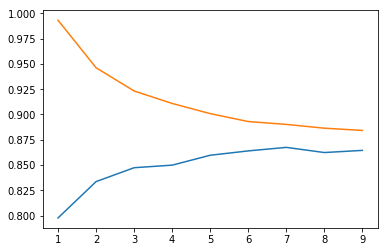

In [19]:
scoretest = []
scoretrain = []
for n in range(1,10):
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    scoretest.append(knn.score(X_test, y_test))
    scoretrain.append(knn.score(X_train, y_train))
    
plt.plot(range(1,10), scoretest)
plt.plot(range(1,10), scoretrain)
plt.show()

Take the optimal hyperparameter

In [20]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)

print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of kNN on train set: 0.89
Accuracy of kNN on test set: 0.87


From the accuracy results of the above training, we can see that except for kNN, all of them have relatively good results for accuracy around 0.5.

# Feature Engineering

### Add 1/x columns

In [21]:
hainan = hainan.drop(['BioCNG_Produced_binned'], axis=1)

In [22]:
for col in hainan.columns[1:]:
    hainan['1/'+col] = 1/(hainan[col])
    
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037821
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.034578
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037175
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,inf,inf,0.111111,inf,inf,inf,inf,inf,inf,inf


Replace invalid values

In [23]:
hainan.replace(float('inf'), 0, inplace=True)
train_data, test_data = train_test_split(hainan, test_size=0.2)

In [24]:
INVERSE_COLUMNS = [ 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
                    'Fish_waste_water_t', 'Kitchen_food_waste_t',
                    'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
                    'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
                    'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
                    'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
                    '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
                    '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
                    '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
                    '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
                    '1/Percolate_t', '1/Other_waste_t' ]

X_train = train_data[INVERSE_COLUMNS]
y_train = train_data.BioCNG_Produced_m3
X_test = test_data[INVERSE_COLUMNS]
y_test = test_data.BioCNG_Produced_m3

In [25]:
y_pred_train = hainan_ols.predict(X_train)
y_pred_test = hainan_ols.predict(X_test)

Compute the root-mean-square of training data

In [26]:
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:', rms_train/sum(y_train))

Training error: 0.000234819084938


Compute the root-mean-square of test data

In [27]:
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:', rms_test/sum(y_test))

Testing error: 0.000963716293672


#### Logistic regression

Bin the data and reset test and train data

In [28]:
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
train_data, test_data = train_test_split(hainan, test_size=0.2)
y_train = train_data.BioCNG_Produced_binned
y_test = test_data.BioCNG_Produced_binned

In [29]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_test))

Accuracy of logistic regression classifier on training set: 0.60
Accuracy of logistic regression classifier on test set: 0.61
Confusion matrix:
[[166   1   1]
 [ 76   1   0]
 [ 30   0   0]]


#### SVM

In [30]:
clf = svm.SVC()
clf.fit(X_train, y_train)  

print('Accuracy of SVM on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on training set: 0.98
Accuracy of SVM on test set: 0.60


#### Perceptron

In [31]:
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)

print('Accuracy of perceptron on training set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on training set: 0.59
Accuracy of perceptron on test set: 0.60


#### KNN

Normalize data

In [32]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']])

hainan_normalized = pd.DataFrame(np_scaled)

Reset train and test data

In [33]:
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]

Run KNN

In [34]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xnor_train, ynor_train)

print('Accuracy of kNN on training set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))

Accuracy of kNN on training set: 0.89
Accuracy of kNN on test set: 0.86


#### Random forest

In [35]:
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)

print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.99
Accuracy of Random Forest on test set: 0.57


### Add x^2 columns

In [36]:
hainan = hainan.drop(['BioCNG_Produced_binned'], axis=1)

In [37]:
for col in hainan.columns[1:]:
    hainan[col+"**2"] = (hainan[col])**2
    
hainan.head()

,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,...,1/Tea_waste_t**2,1/Chicken_litter_t**2,1/Bagasse_feed_t**2,1/Alcohol_waste_t**2,1/Chinese_medicine_waste_t**2,1/Energy_grass_t**2,1/Banana_fruit_shafts_t**2,1/Lemon_waste_t**2,1/Percolate_t**2,1/Other_waste_t**2
0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001430
1,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001196
2,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001382
3,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.012346,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [38]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)

In [39]:
SQUARED_COLUMNS = [ 'Pig_Manure_t', 'Cassava_t', 'Fish_waste_water_t',
                    'Kitchen_food_waste_t', 'Municipal_fecal_residue_t', 'Tea_waste_t',
                    'Chicken_litter_t', 'Bagasse_feed_t', 'Alcohol_waste_t',
                    'Chinese_medicine_waste_t', 'Energy_grass_t', 'Banana_fruit_shafts_t',
                    'Lemon_waste_t', 'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t',
                    '1/Cassava_t', '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
                    '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
                    '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
                    '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
                    '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
                    'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
                    'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
                    'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
                    'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
                    'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
                    'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
                    '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
                    '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
                    '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
                    '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
                    '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
                    '1/Other_waste_t**2' ]

X_train = hainan_train[SQUARED_COLUMNS]
y_train = hainan_train.BioCNG_Produced_m3
X_test = hainan_test[SQUARED_COLUMNS]
y_test = hainan_test.BioCNG_Produced_m3

In [40]:
y_pred_train = hainan_ols.predict(X_train)
y_pred_test = hainan_ols.predict(X_test)

Compute the root-mean-square of training data

In [41]:
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:', rms_train/sum(y_train))

Training error: 0.000226771424287


Compute the root-mean-square of test data

In [42]:
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:', rms_test/sum(y_test))

Testing error: 0.00110230490533


#### Logistic regression

Bin the data and reset test and train data

In [43]:
hainan['BioCNG_Produced_binned'] = pd.cut(hainan['BioCNG_Produced_m3'], bins=3, labels=[0, 1, 2])
train_data, test_data = train_test_split(hainan, test_size=0.2)
y_train = train_data.BioCNG_Produced_binned
y_test = test_data.BioCNG_Produced_binned

In [44]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_test))

Accuracy of logistic regression classifier on training set: 0.58
Accuracy of logistic regression classifier on test set: 0.61
Confusion matrix:
[[166   6   3]
 [ 56   1   0]
 [ 43   0   0]]


#### SVM

In [45]:
clf = svm.SVC()
clf.fit(X_train, y_train)  

print('Accuracy of SVM on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on training set: 0.94
Accuracy of SVM on test set: 0.62


#### Perceptron

In [46]:
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)

print('Accuracy of perceptron on training set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on training set: 0.41
Accuracy of perceptron on test set: 0.46


#### KNN

Normalize data

In [47]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']])

hainan_normalized = pd.DataFrame(np_scaled)

Reset train and test data

In [48]:
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]

Run KNN

In [49]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(Xnor_train, ynor_train)

print('Accuracy of kNN on training set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))

Accuracy of kNN on training set: 0.89
Accuracy of kNN on test set: 0.87


#### Random forest

In [50]:
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)

print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.97
Accuracy of Random Forest on test set: 0.53
